# 1. Model Training

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

class_names = ['paper', 'rock', 'scissors']

def get_image_gens():

    train_dir = './data/train/'
    valid_dir = './data/valid/'
    test_dir = './data/test/'

    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    val_datagen = ImageDataGenerator(rescale=1/255)
    test_datagen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(75, 75),
        batch_size=214,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        valid_dir,
        target_size=(75, 75),
        batch_size=37,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(75, 75),
        batch_size=37,
        class_mode='categorical'
    )
    
    return train_generator, val_generator, test_generator


def build_model(pre_trained_model, last_output):

    x = Flatten()(last_output)
    
    # Dense hidden layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    # Output neuron. 
    x = Dense(3, activation='softmax')(x)
    
    model = Model(pre_trained_model.input, x)
    
    return model

train_generator, validation_generator, test_generator = get_image_gens()

pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed3')
last_output = last_layer.output

model = build_model(pre_trained_model, last_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_TL = model.fit(
      train_generator,
      epochs=5,
      verbose=1,
      validation_data = validation_generator)

tf.keras.models.save_model(model,'./models/my_model.keras')



Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Found 0 images belonging to 0 classes.
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 0.4750 - loss: 8.2110 - val_accuracy: 0.5430 - val_loss: 1.2570
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 502ms/step - accuracy: 0.7452 - loss: 0.6830 - val_accuracy: 0.8522 - val_loss: 0.2601
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 505ms/step - accuracy: 0.9115 - loss: 0.2433 - val_accuracy: 0.8468 - val_loss: 0.2526
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step - accuracy: 0.9615 - loss: 0.1289 - val_accuracy: 0.9624 - val_loss: 0.1147
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 503ms/step - accuracy: 0.9794 - loss: 0.0898 - val_accuracy: 0.9866 - val_loss: 0.1178


### ⭐ Save the Model as a .keras File (so it can be reused later)

In [ ]:
import os

# get id for new model
folder = "./models/"
id = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
default_filename = f"model{id}"

new_model_filename = input(f"Enter filename (Default: {default_filename}): ")
if new_model_filename.strip() == "":
    new_model_filename = default_filename
tf.keras.models.save_model(model, f'./models/{new_model_filename}.keras')

# 2. Trying the Model

### 🔃 Load a .keras model
Loading a model is necessary if the above code to train a new model was not executed.
(Skip this if model was recently trained above)

In [2]:
import os
import tensorflow as tf

folder = "./models/"
files = os.listdir(folder)

# sort by last added time
if not files: raise FileNotFoundError("No models found!")
files_sorted = sorted(files, key=lambda f: os.path.getmtime(os.path.join(folder, f)))
last_added_filename = files_sorted[-1]

while True:
    input_filename = input(
        f"Enter model to load (Latest: {last_added_filename.replace('.keras', '')}): "
    ).strip()

    if input_filename == "":
        model_filename = last_added_filename
        break

    model_filename = f"{input_filename.replace('.keras', '')}.keras"
    full_path = os.path.join(folder, model_filename)

    if os.path.exists(full_path):
        break
    else:
        print("❌ Model not found. Please try again.")

model = tf.keras.models.load_model(f'./models/{model_filename}')

print("✅ Model Loaded:", model_filename)

c:\Users\bryon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✅ Model Loaded: model3.keras


### Part 2A: Inference using Tensorflow Camera
(Please view the cell under this one to terminate the camera)

In [9]:
import threading
import cv2
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf

def import_and_predict(image_data):
    image = ImageOps.fit(image_data, (75, 75), Image.Resampling.LANCZOS)
    image = image.convert('RGB')
    image = np.asarray(image)
    image = (image.astype(np.float32) / 255.0)
    img_reshape = image[np.newaxis,...]
    prediction = model.predict(img_reshape, verbose=0)
    return prediction

stop_flag = False

def camera_loop():
    global stop_flag
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        cap.open()
        
    print("Camera Started!")

    while not stop_flag:
        ret, original = cap.read()
        if not ret:
            break

        image = Image.fromarray(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        prediction = import_and_predict(image)

        map = {0: "paper",
               1: "rock",
               2: "scissor"}

        idx = np.argmax(prediction)
        confidence = prediction[0][idx] 

        predict = f"It is a {map[idx]}! ({confidence:.2f})"

        cv2.putText(original, predict, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.imshow("Classification", original)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            stop_flag = True

    cap.release()
    cv2.destroyAllWindows()

# start the camera in a separate thread
camera_thread = threading.Thread(target=camera_loop)
camera_thread.start()


Camera Started!


✋ Run to terminate the camera!
   👇

In [8]:
stop_flag = True
camera_thread.join()
print("Stopped!")

Stopped!


### Part 2B: Inference using Folder of Images
For this part, please put the images you want to test into "./data/test/"

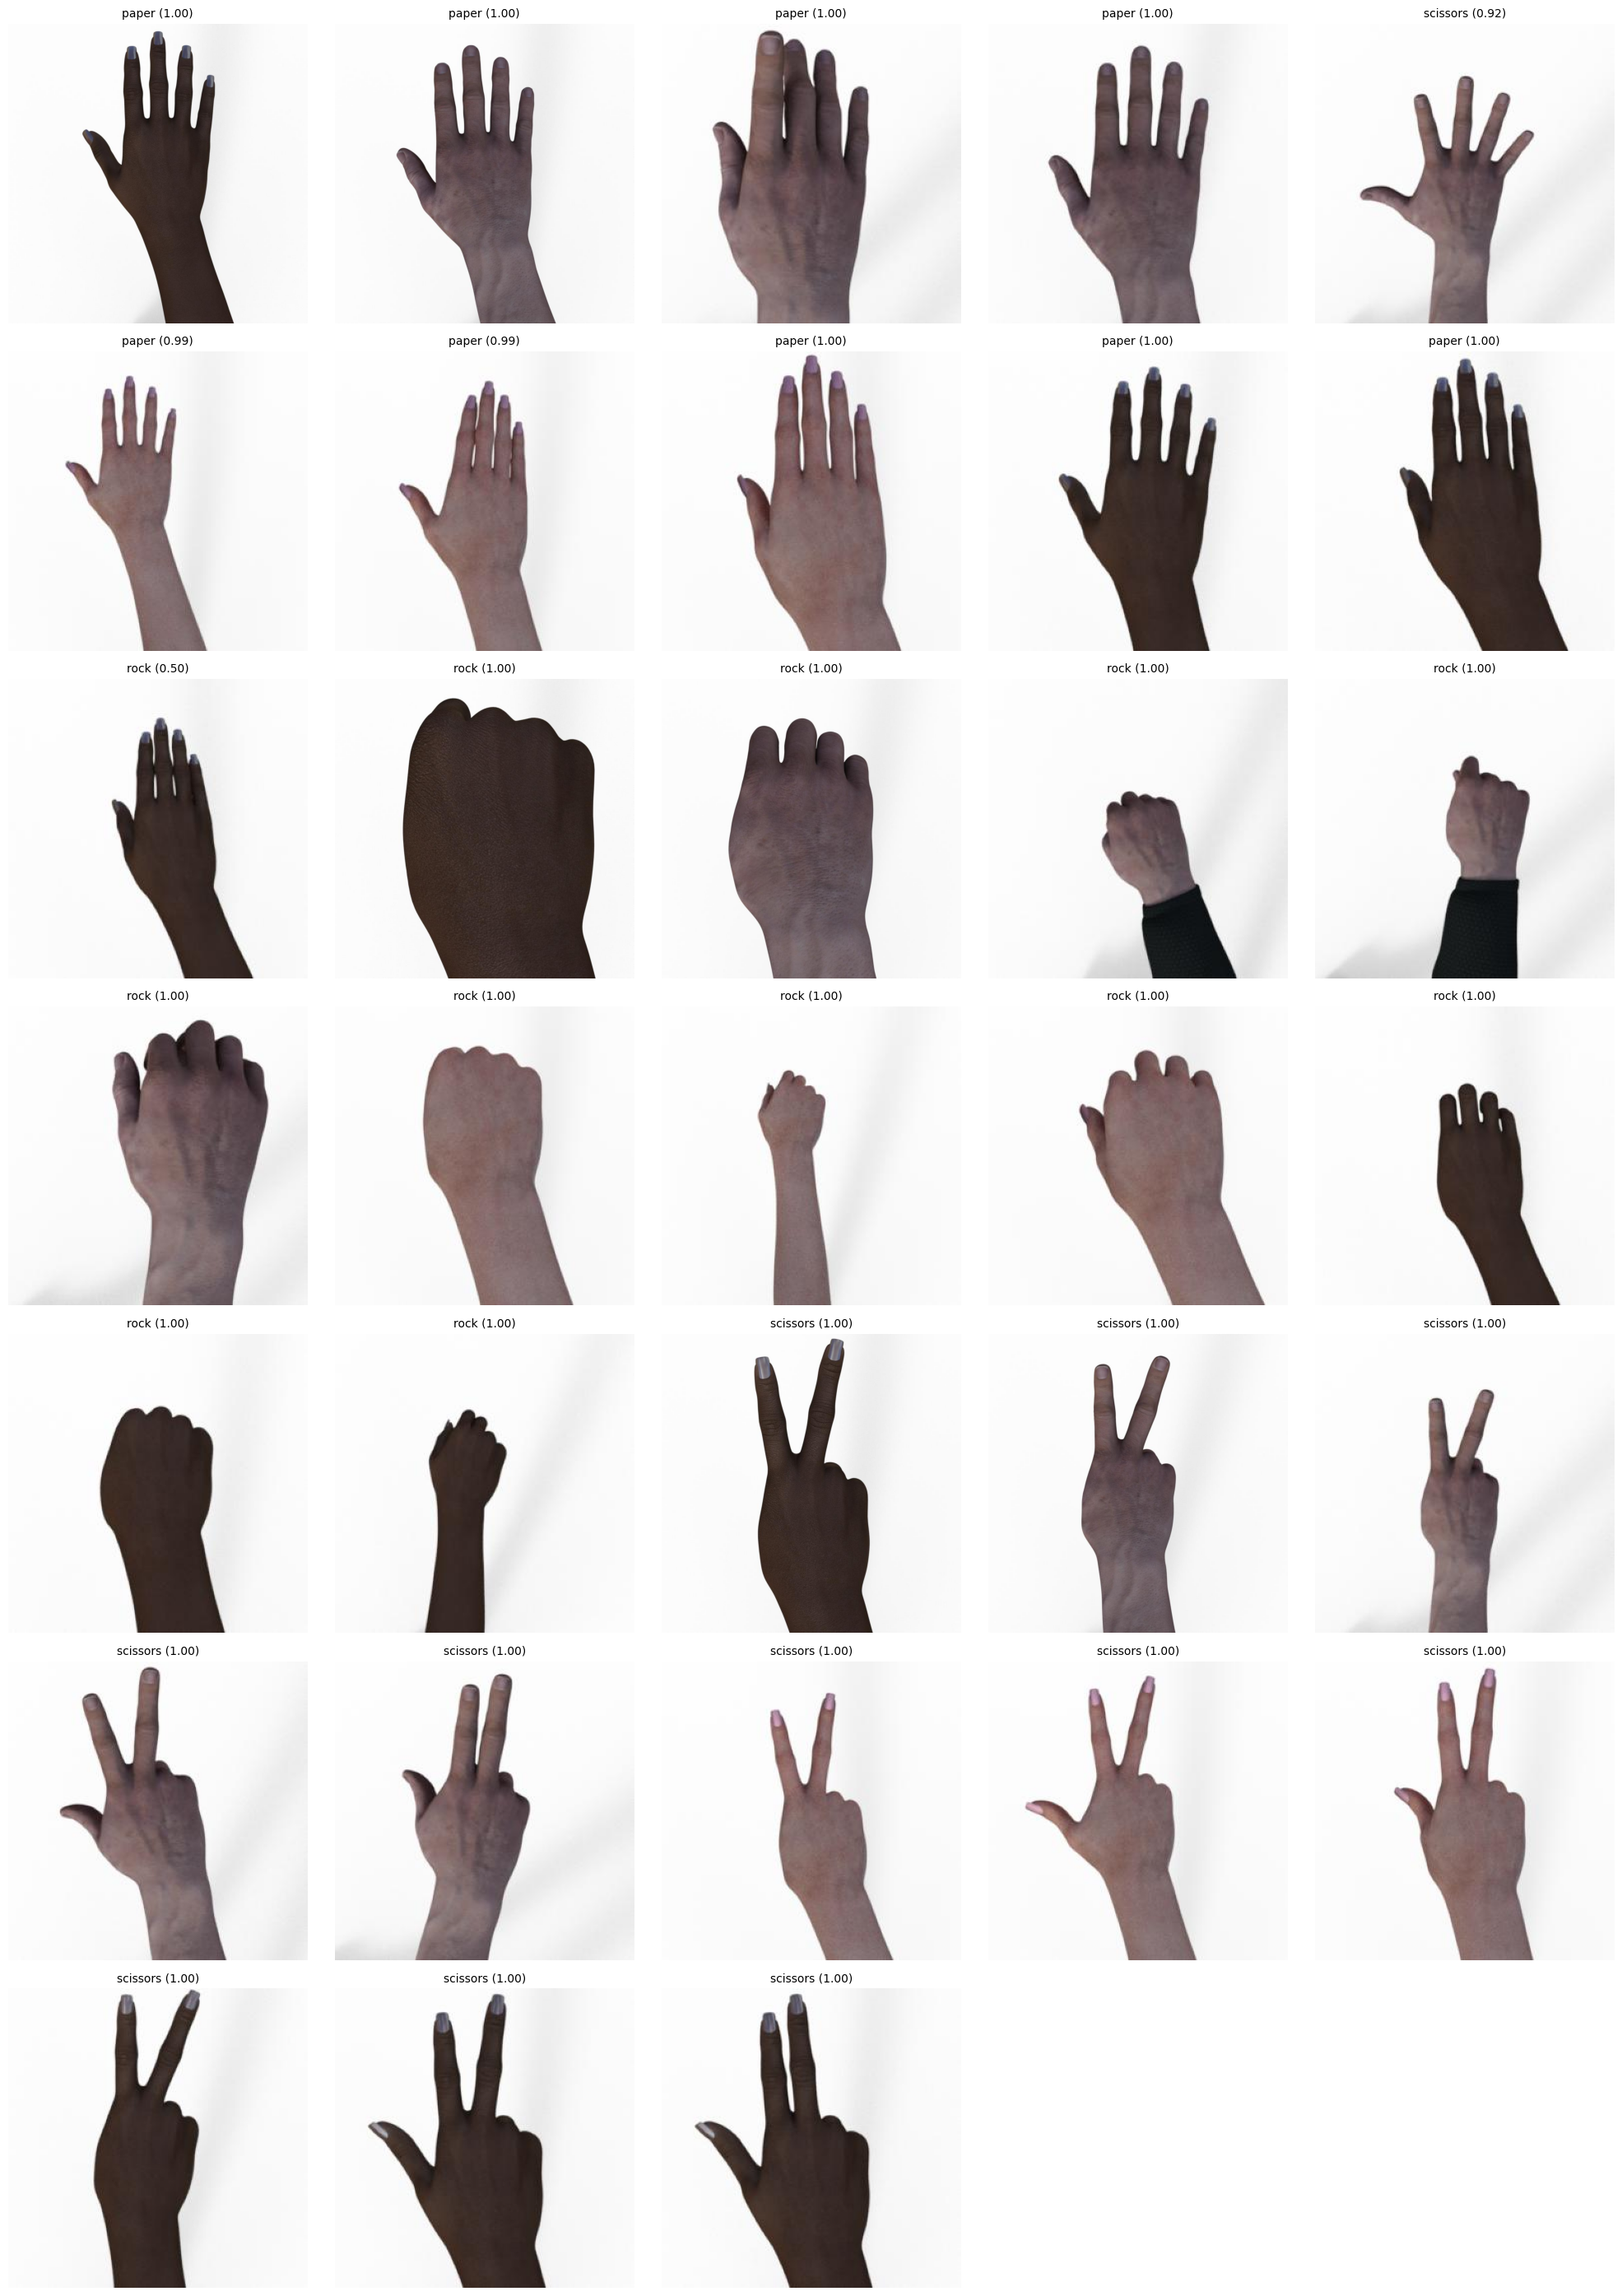

In [19]:
COLUMNS = 5

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

def visualize_predictions(images_folder: str, class_names: list[str]) -> None:
    all_images = [f for f in os.listdir(images_folder)
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    rows = math.ceil(len(all_images) / COLUMNS)
    plt.figure(figsize=(COLUMNS * 4, rows * 4))

    for i, img_name in enumerate(all_images):
        img_path = os.path.join(images_folder, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Preprocess
        img_resized = cv2.resize(img, (75, 75))
        img_norm = img_resized / 255.0
        img_input = np.expand_dims(img_norm, axis=0)

        # Predict
        preds = model.predict(img_input, verbose=0)
        class_id = np.argmax(preds[0])
        confidence = preds[0][class_id]
        label = f"{class_names[class_id]} ({confidence:.2f})"

        # Plot
        plt.subplot(rows, COLUMNS, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions('./data/test/', ['paper', 'rock', 'scissors'])